In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import joblib
import sys
from pathlib import Path
from datetime import datetime

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Configure settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')
np.random.seed(42)

print("🤖 Model Experiments and Comparison")
print(f"📅 Started at: {datetime.now()}")


🤖 Model Experiments and Comparison
📅 Started at: 2025-10-03 16:22:45.572540


In [2]:
# Load processed data
print("📂 Loading Processed Data...")

try:
    # Try to load pre-processed data
    processed_dir = Path('../data/processed')
    
    df_processed = pd.read_csv(processed_dir / 'processed_data.csv')
    print(f"✅ Processed data loaded: {df_processed.shape}")
    
    # Load train-test splits if available
    if (processed_dir / 'X_train.csv').exists():
        X_train = pd.read_csv(processed_dir / 'X_train.csv')
        X_test = pd.read_csv(processed_dir / 'X_test.csv')
        y_train = pd.read_csv(processed_dir / 'y_train.csv')['price']
        y_test = pd.read_csv(processed_dir / 'y_test.csv')['price']
        
        print(f"✅ Pre-split data loaded:")
        print(f"   Train: {X_train.shape}, Test: {X_test.shape}")
        
        data_loaded = True
    else:
        print("⚠️ Pre-split data not found, will create splits")
        data_loaded = False
        
except FileNotFoundError:
    print("❌ Processed data not found. Loading raw data and processing...")
    
    # Load raw data and do basic processing
    try:
        df_raw = pd.read_csv('../data/raw/bengaluru_house_prices.csv')
    except FileNotFoundError:
        # Create sample data
        np.random.seed(42)
        n_samples = 2000
        locations = ['Whitefield', 'Electronic City', 'Marathahalli', 'BTM Layout', 'Koramangala', 
                    'HSR Layout', 'Indiranagar', 'Jayanagar']
        
        df_raw = pd.DataFrame({
            'location': np.random.choice(locations, n_samples),
            'total_sqft': np.random.normal(1200, 400, n_samples),
            'size': [f"{np.random.choice([1,2,3,4])} BHK" for _ in range(n_samples)],
            'bath': np.random.randint(1, 5, n_samples),
            'balcony': np.random.randint(0, 4, n_samples),
            'price': np.random.normal(80, 30, n_samples)
        })
        df_raw['total_sqft'] = np.maximum(df_raw['total_sqft'], 500)
        df_raw['price'] = np.maximum(df_raw['price'], 20)
        
        print("📊 Sample data created for experiments")
    
    # Quick processing
    df_processed = df_raw.copy()
    
    # Extract BHK from size
    df_processed['bhk'] = df_processed['size'].str.extract('(\d+)').astype(int)
    
    # Fill missing balcony
    df_processed['balcony'] = df_processed['balcony'].fillna(0)
    
    data_loaded = False

print(f"\n📊 Dataset Overview:")
print(f"Shape: {df_processed.shape}")
print(f"Columns: {list(df_processed.columns)}")
display(df_processed.head())


📂 Loading Processed Data...
✅ Processed data loaded: (10071, 21)
✅ Pre-split data loaded:
   Train: (8056, 9), Test: (2015, 9)

📊 Dataset Overview:
Shape: (10071, 21)
Columns: ['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 'balcony', 'price', 'bhk', 'sqft_per_room', 'price_per_sqft', 'price_category', 'bath_per_bhk', 'total_rooms', 'location_frequency', 'location_tier', 'has_balcony', 'is_luxury', 'price_efficiency', 'space_efficiency']


,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk,sqft_per_room,price_per_sqft,price_category,bath_per_bhk,total_rooms,location_frequency,location_tier,has_balcony,is_luxury,price_efficiency,space_efficiency
0,Super built-up Area,19-Dec,Electronic City Phase Ii,2 BHK,Coomee,1056.0,2.0,1.0,39.07,2.0,528.0,3699.810606,Mid-range,1.000000,5.0,119,Budget,1,0,1.016675,211.200000
1,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440.0,2.0,3.0,62.00,3.0,480.0,4305.555556,Premium,0.666667,8.0,148,Budget,1,0,0.988893,180.000000
2,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521.0,3.0,1.0,95.00,3.0,507.0,6245.890861,Premium,1.000000,7.0,23,Premium,1,0,0.944412,217.285714
3,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200.0,2.0,1.0,51.00,2.0,600.0,4250.000000,Mid-range,1.000000,5.0,53,Mid-tier,1,0,0.821310,240.000000
4,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170.0,2.0,1.0,38.00,2.0,585.0,3247.863248,Mid-range,1.000000,5.0,401,Mid-tier,1,0,0.614191,234.000000


In [3]:
# Prepare data for modeling
print("🔧 Preparing Data for Modeling...")

if not data_loaded:
    # Create features for modeling
    feature_columns = []
    
    # Numerical features
    numerical_features = ['total_sqft', 'bhk', 'bath', 'balcony']
    feature_columns.extend([col for col in numerical_features if col in df_processed.columns])
    
    # Encode location if present
    if 'location' in df_processed.columns:
        le_location = LabelEncoder()
        df_processed['location_encoded'] = le_location.fit_transform(df_processed['location'])
        feature_columns.append('location_encoded')
    
    # Create derived features
    if 'total_sqft' in df_processed.columns and 'bhk' in df_processed.columns:
        df_processed['sqft_per_room'] = df_processed['total_sqft'] / df_processed['bhk']
        feature_columns.append('sqft_per_room')
    
    if 'bath' in df_processed.columns and 'bhk' in df_processed.columns:
        df_processed['bath_per_bhk'] = df_processed['bath'] / df_processed['bhk']
        feature_columns.append('bath_per_bhk')
    
    # Create feature matrix
    X = df_processed[feature_columns].copy()
    y = df_processed['price'].copy()
    
    # Handle any missing values
    X = X.fillna(X.median())
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"✅ Data preparation completed")
    print(f"   Features: {feature_columns}")

print(f"\n📊 Final Data for Modeling:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Feature columns: {list(X_train.columns)}")

# Feature statistics
print(f"\n📈 Feature Statistics:")
display(X_train.describe().round(2))


🔧 Preparing Data for Modeling...

📊 Final Data for Modeling:
Training set: (8056, 9)
Test set: (2015, 9)
Feature columns: ['total_sqft', 'bhk', 'bath', 'balcony', 'price_per_sqft', 'sqft_per_room', 'bath_per_bhk', 'location_frequency', 'has_balcony']

📈 Feature Statistics:


,total_sqft,bhk,bath,balcony,price_per_sqft,sqft_per_room,bath_per_bhk,location_frequency,has_balcony
count,8056.00,8056.00,8056.00,8056.00,8056.00,8056.00,8056.00,8056.00,8056.00
mean,1289.98,2.40,2.26,1.53,5523.30,549.58,0.96,80.82,0.91
std,340.36,0.65,0.64,0.80,2157.15,109.66,0.16,102.18,0.28
min,375.00,1.00,1.00,0.00,1166.67,300.00,0.33,1.00,0.00
25%,1090.00,2.00,2.00,1.00,4135.57,485.00,1.00,12.00,1.00
50%,1230.00,2.00,2.00,2.00,5077.19,550.00,1.00,39.00,1.00
75%,1500.00,3.00,3.00,2.00,6354.47,605.00,1.00,119.00,1.00
max,2270.00,4.00,4.00,3.00,24166.67,1806.00,2.00,401.00,1.00


In [4]:
# Define models to experiment with
print("🎯 Configuring Models for Experiments...")

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    
    'Extra Trees': ExtraTreesRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ),
    
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        random_state=42
    ),
    
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    
    'Support Vector Regression': SVR(kernel='rbf', C=1.0)
}

print(f"✅ Configured {len(models)} models for comparison:")
for name in models.keys():
    print(f"   • {name}")


🎯 Configuring Models for Experiments...
✅ Configured 10 models for comparison:
   • Linear Regression
   • Ridge Regression
   • Lasso Regression
   • ElasticNet
   • Decision Tree
   • Random Forest
   • Extra Trees
   • Gradient Boosting
   • K-Nearest Neighbors
   • Support Vector Regression


In [5]:
# Cross-validation evaluation of all models
print("📊 Cross-Validation Evaluation...")

def evaluate_model_cv(model, X, y, cv_folds=5, scoring='r2'):
    """Evaluate model using cross-validation"""
    scores = cross_val_score(model, X, y, cv=cv_folds, scoring=scoring)
    return {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }

# Evaluate all models
cv_results = {}
cv_folds = 5

print(f"Running {cv_folds}-fold cross-validation for all models...")

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    try:
        # R² score
        r2_results = evaluate_model_cv(model, X_train, y_train, cv_folds, 'r2')
        
        # MAE score
        mae_results = evaluate_model_cv(model, X_train, y_train, cv_folds, 'neg_mean_absolute_error')
        mae_results['mean'] = -mae_results['mean']  # Convert back to positive
        mae_results['scores'] = -mae_results['scores']
        
        # RMSE score
        rmse_results = evaluate_model_cv(model, X_train, y_train, cv_folds, 'neg_mean_squared_error')
        rmse_results['mean'] = np.sqrt(-rmse_results['mean'])
        rmse_results['scores'] = np.sqrt(-rmse_results['scores'])
        
        cv_results[name] = {
            'r2': r2_results,
            'mae': mae_results,
            'rmse': rmse_results
        }
        
        print(f"   R² Score: {r2_results['mean']:.4f} (±{r2_results['std']:.4f})")
        print(f"   MAE: {mae_results['mean']:.2f} (±{mae_results['std']:.2f})")
        print(f"   RMSE: {rmse_results['mean']:.2f} (±{rmse_results['std']:.2f})")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")
        cv_results[name] = None

print(f"\n✅ Cross-validation completed for {len([k for k, v in cv_results.items() if v is not None])} models")


📊 Cross-Validation Evaluation...
Running 5-fold cross-validation for all models...

Evaluating Linear Regression...
   R² Score: 0.9593 (±0.0052)
   MAE: 4.16 (±0.06)
   RMSE: 7.38 (±4.69)

Evaluating Ridge Regression...
   R² Score: 0.9593 (±0.0052)
   MAE: 4.16 (±0.06)
   RMSE: 7.38 (±4.70)

Evaluating Lasso Regression...
   R² Score: 0.9587 (±0.0053)
   MAE: 4.23 (±0.07)
   RMSE: 7.43 (±4.69)

Evaluating ElasticNet...
   R² Score: 0.9587 (±0.0053)
   MAE: 4.23 (±0.07)
   RMSE: 7.43 (±4.69)

Evaluating Decision Tree...
   R² Score: 0.9945 (±0.0018)
   MAE: 1.04 (±0.13)
   RMSE: 2.72 (±2.46)

Evaluating Random Forest...
   R² Score: 0.9977 (±0.0013)
   MAE: 0.55 (±0.06)
   RMSE: 1.76 (±1.67)

Evaluating Extra Trees...
   R² Score: 0.9986 (±0.0008)
   MAE: 0.36 (±0.04)
   RMSE: 1.35 (±1.10)

Evaluating Gradient Boosting...
   R² Score: 0.9966 (±0.0004)
   MAE: 1.37 (±0.04)
   RMSE: 2.12 (±0.43)

Evaluating K-Nearest Neighbors...
   R² Score: 0.9879 (±0.0028)
   MAE: 1.45 (±0.04)
   RMS

In [6]:
# Train models on full training set and evaluate on test set
print("🚀 Training Models on Full Dataset...")

# Scale features for algorithms that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Models that need scaling
scaling_models = ['Support Vector Regression', 'K-Nearest Neighbors']

# Training and testing results
test_results = {}

for name, model in models.items():
    if cv_results.get(name) is None:
        continue
        
    print(f"\nTraining {name}...")
    
    try:
        # Choose scaled or unscaled data
        if name in scaling_models:
            X_train_use = X_train_scaled_df
            X_test_use = X_test_scaled_df
        else:
            X_train_use = X_train
            X_test_use = X_test
        
        # Train model
        model.fit(X_train_use, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train_use)
        y_test_pred = model.predict(X_test_use)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Calculate residuals
        residuals = y_test - y_test_pred
        
        test_results[name] = {
            'model': model,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'test_mape': test_mape,
            'predictions': y_test_pred,
            'residuals': residuals,
            'cv_r2_mean': cv_results[name]['r2']['mean'],
            'cv_r2_std': cv_results[name]['r2']['std']
        }
        
        print(f"   Train R²: {train_r2:.4f}")
        print(f"   Test R²: {test_r2:.4f}")
        print(f"   Test MAE: {test_mae:.2f}")
        print(f"   Test RMSE: {test_rmse:.2f}")
        print(f"   Test MAPE: {test_mape:.4f}")
        
        # Check for overfitting
        overfitting = train_r2 - test_r2
        if overfitting > 0.1:
            print(f"   ⚠️ Potential overfitting detected (difference: {overfitting:.4f})")
        
    except Exception as e:
        print(f"   ❌ Training failed: {str(e)}")
        test_results[name] = None

print(f"\n✅ Model training completed")


🚀 Training Models on Full Dataset...

Training Linear Regression...
   Train R²: 0.9600
   Test R²: 0.9237
   Test MAE: 4.91
   Test RMSE: 10.83
   Test MAPE: 0.0857

Training Ridge Regression...
   Train R²: 0.9600
   Test R²: 0.9237
   Test MAE: 4.91
   Test RMSE: 10.83
   Test MAPE: 0.0857

Training Lasso Regression...
   Train R²: 0.9593
   Test R²: 0.9229
   Test MAE: 4.99
   Test RMSE: 10.89
   Test MAPE: 0.0881

Training ElasticNet...
   Train R²: 0.9593
   Test R²: 0.9229
   Test MAE: 4.99
   Test RMSE: 10.89
   Test MAPE: 0.0881

Training Decision Tree...
   Train R²: 1.0000
   Test R²: 0.9891
   Test MAE: 1.27
   Test RMSE: 4.09
   Test MAPE: 0.0146

Training Random Forest...
   Train R²: 0.9998
   Test R²: 0.9947
   Test MAE: 0.62
   Test RMSE: 2.84
   Test MAPE: 0.0075

Training Extra Trees...
   Train R²: 1.0000
   Test R²: 0.9930
   Test MAE: 0.49
   Test RMSE: 3.28
   Test MAPE: 0.0056

Training Gradient Boosting...
   Train R²: 0.9977
   Test R²: 0.9920
   Test MAE: 1.4

In [7]:
# Create comprehensive results comparison
print("📊 Model Performance Comparison")

# Create results DataFrame
results_data = []

for name, results in test_results.items():
    if results is not None:
        results_data.append({
            'Model': name,
            'CV_R2_Mean': results['cv_r2_mean'],
            'CV_R2_Std': results['cv_r2_std'],
            'Train_R2': results['train_r2'],
            'Test_R2': results['test_r2'],
            'Test_MAE': results['test_mae'],
            'Test_RMSE': results['test_rmse'],
            'Test_MAPE': results['test_mape'],
            'Overfitting': results['train_r2'] - results['test_r2']
        })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Test_R2', ascending=False)

print("\n🏆 Model Performance Rankings:")
display(results_df.round(4))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model_results = test_results[best_model_name]

print(f"\n🥇 Best Model: {best_model_name}")
print(f"   Test R² Score: {best_model_results['test_r2']:.4f}")
print(f"   Test MAE: {best_model_results['test_mae']:.2f} lakhs")
print(f"   Test RMSE: {best_model_results['test_rmse']:.2f} lakhs")


📊 Model Performance Comparison

🏆 Model Performance Rankings:


,Model,CV_R2_Mean,CV_R2_Std,Train_R2,Test_R2,Test_MAE,Test_RMSE,Test_MAPE,Overfitting
5,Random Forest,0.9977,0.0013,0.9998,0.9947,0.6245,2.8419,0.0075,0.0050
6,Extra Trees,0.9986,0.0008,1.0000,0.9930,0.4874,3.2781,0.0056,0.0070
7,Gradient Boosting,0.9966,0.0004,0.9977,0.9920,1.4936,3.5075,0.0206,0.0057
4,Decision Tree,0.9945,0.0018,1.0000,0.9891,1.2686,4.0926,0.0146,0.0109
8,K-Nearest Neighbors,0.9879,0.0028,0.9800,0.9600,3.6325,7.8455,0.0482,0.0200
0,Linear Regression,0.9593,0.0052,0.9600,0.9237,4.9140,10.8326,0.0857,0.0363
1,Ridge Regression,0.9593,0.0052,0.9600,0.9237,4.9146,10.8340,0.0857,0.0363
3,ElasticNet,0.9587,0.0053,0.9593,0.9229,4.9910,10.8874,0.0881,0.0364
2,Lasso Regression,0.9587,0.0053,0.9593,0.9229,4.9907,10.8875,0.0881,0.0364
9,Support Vector Regression,0.9447,0.0051,0.9110,0.8594,4.5657,14.7063,0.0524,0.0517



🥇 Best Model: Random Forest
   Test R² Score: 0.9947
   Test MAE: 0.62 lakhs
   Test RMSE: 2.84 lakhs


📈 Creating Performance Visualizations...


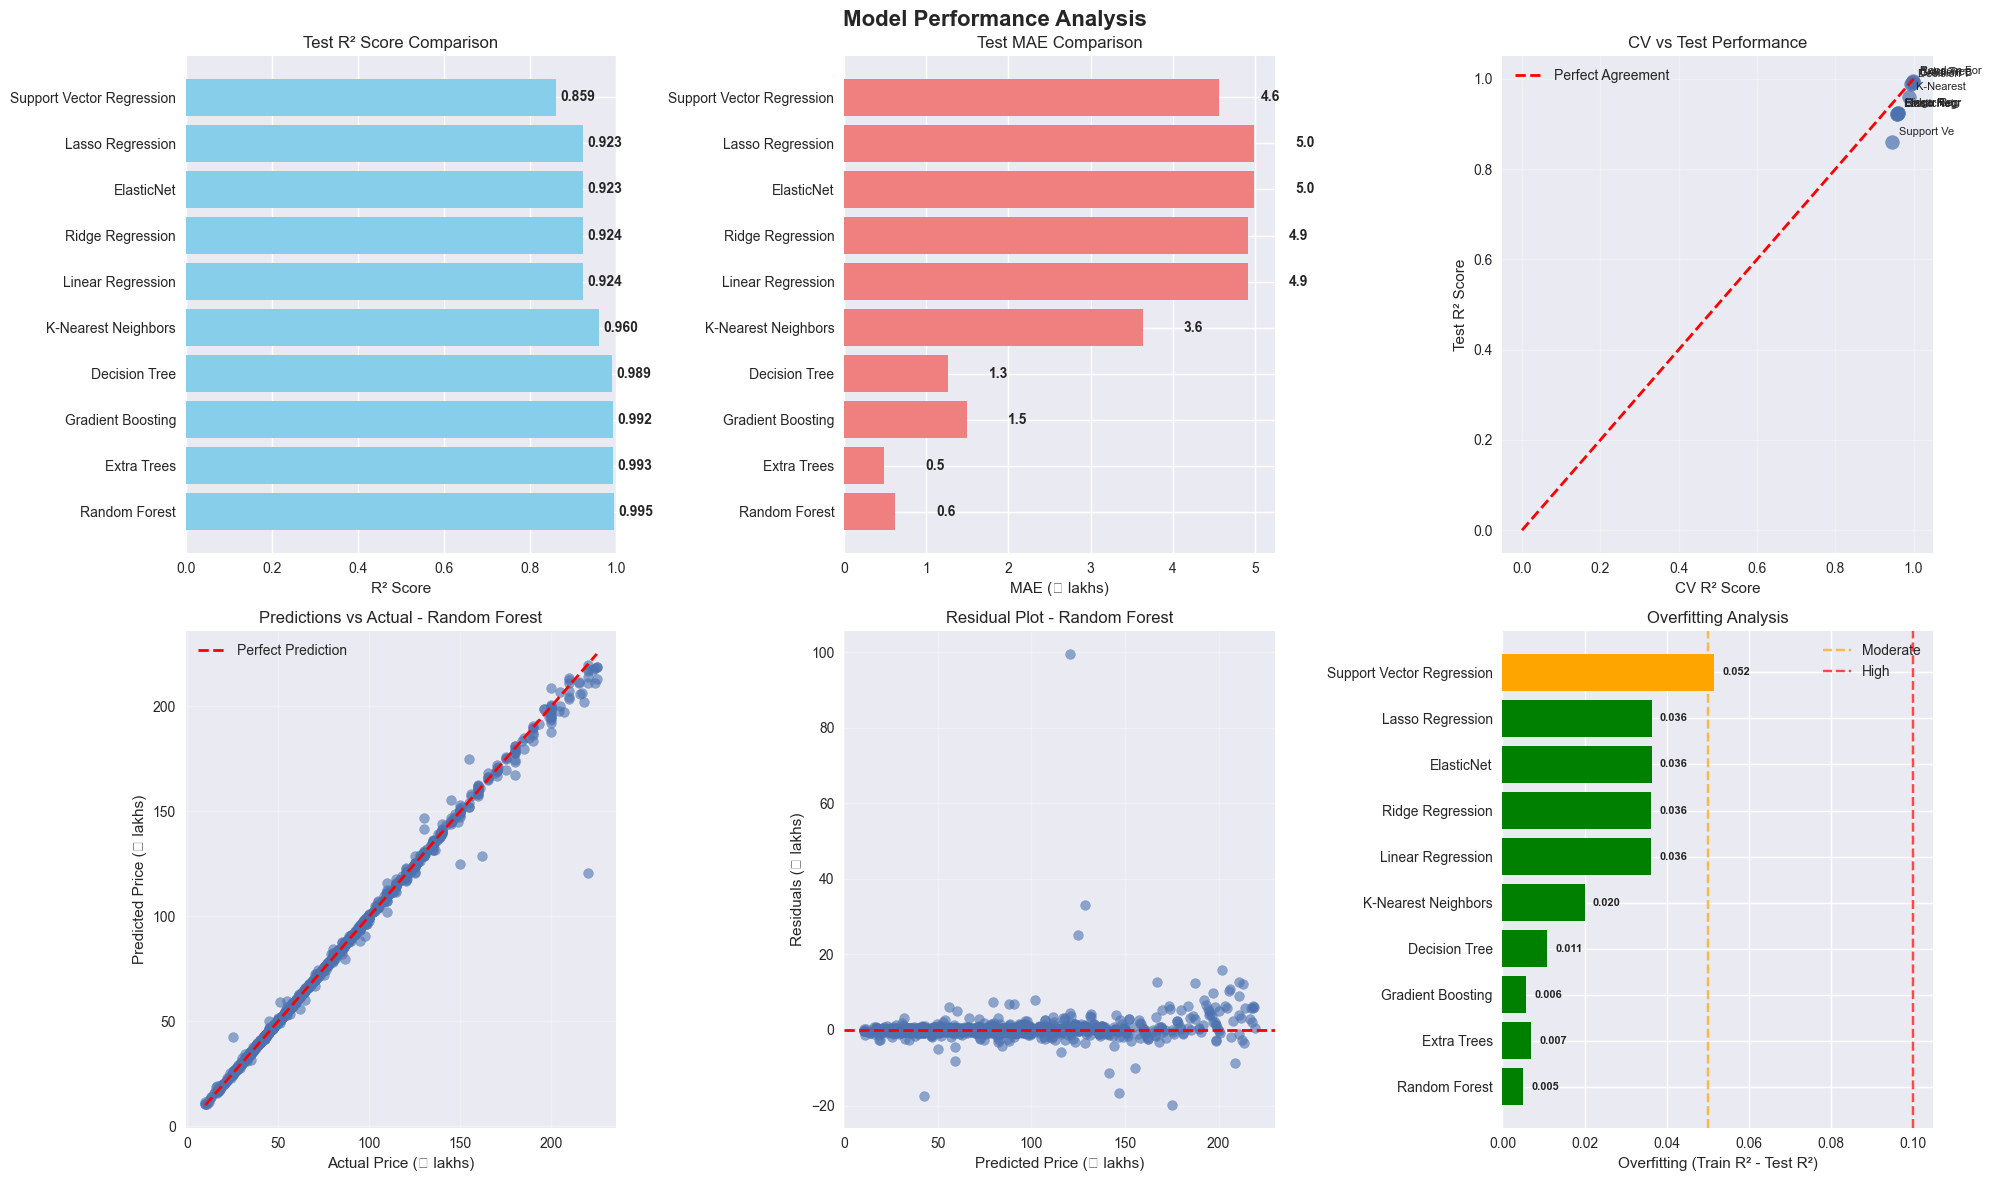

In [8]:
# Visualize model performance
print("📈 Creating Performance Visualizations...")

# Set up the plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. R² Score Comparison
ax1 = axes[0, 0]
model_names = results_df['Model'].values
r2_scores = results_df['Test_R2'].values

bars1 = ax1.barh(model_names, r2_scores, color='skyblue')
ax1.set_xlabel('R² Score')
ax1.set_title('Test R² Score Comparison')
ax1.set_xlim(0, 1)

# Add value labels
for bar, score in zip(bars1, r2_scores):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', ha='left', va='center', fontweight='bold')

# 2. MAE Comparison
ax2 = axes[0, 1]
mae_scores = results_df['Test_MAE'].values

bars2 = ax2.barh(model_names, mae_scores, color='lightcoral')
ax2.set_xlabel('MAE (₹ lakhs)')
ax2.set_title('Test MAE Comparison')

for bar, score in zip(bars2, mae_scores):
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{score:.1f}', ha='left', va='center', fontweight='bold')

# 3. Cross-validation vs Test Performance
ax3 = axes[0, 2]
cv_scores = results_df['CV_R2_Mean'].values
test_scores = results_df['Test_R2'].values

ax3.scatter(cv_scores, test_scores, s=100, alpha=0.7)
ax3.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Agreement')
ax3.set_xlabel('CV R² Score')
ax3.set_ylabel('Test R² Score')
ax3.set_title('CV vs Test Performance')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add model labels
for i, name in enumerate(model_names):
    ax3.annotate(name[:10], (cv_scores[i], test_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Predictions vs Actual (Best Model)
ax4 = axes[1, 0]
best_predictions = best_model_results['predictions']

ax4.scatter(y_test, best_predictions, alpha=0.6, s=50)
min_price = min(y_test.min(), best_predictions.min())
max_price = max(y_test.max(), best_predictions.max())
ax4.plot([min_price, max_price], [min_price, max_price], 'r--', lw=2, 
         label='Perfect Prediction')

ax4.set_xlabel('Actual Price (₹ lakhs)')
ax4.set_ylabel('Predicted Price (₹ lakhs)')
ax4.set_title(f'Predictions vs Actual - {best_model_name}')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Residuals Plot (Best Model)
ax5 = axes[1, 1]
residuals = best_model_results['residuals']

ax5.scatter(best_predictions, residuals, alpha=0.6, s=50)
ax5.axhline(y=0, color='red', linestyle='--', lw=2)
ax5.set_xlabel('Predicted Price (₹ lakhs)')
ax5.set_ylabel('Residuals (₹ lakhs)')
ax5.set_title(f'Residual Plot - {best_model_name}')
ax5.grid(True, alpha=0.3)

# 6. Overfitting Analysis
ax6 = axes[1, 2]
overfitting_scores = results_df['Overfitting'].values

colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'green' for x in overfitting_scores]
bars6 = ax6.barh(model_names, overfitting_scores, color=colors)
ax6.set_xlabel('Overfitting (Train R² - Test R²)')
ax6.set_title('Overfitting Analysis')
ax6.axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderate')
ax6.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='High')
ax6.legend()

for bar, score in zip(bars6, overfitting_scores):
    width = bar.get_width()
    ax6.text(width + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', ha='left', va='center', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()


🌳 Feature Importance Analysis...


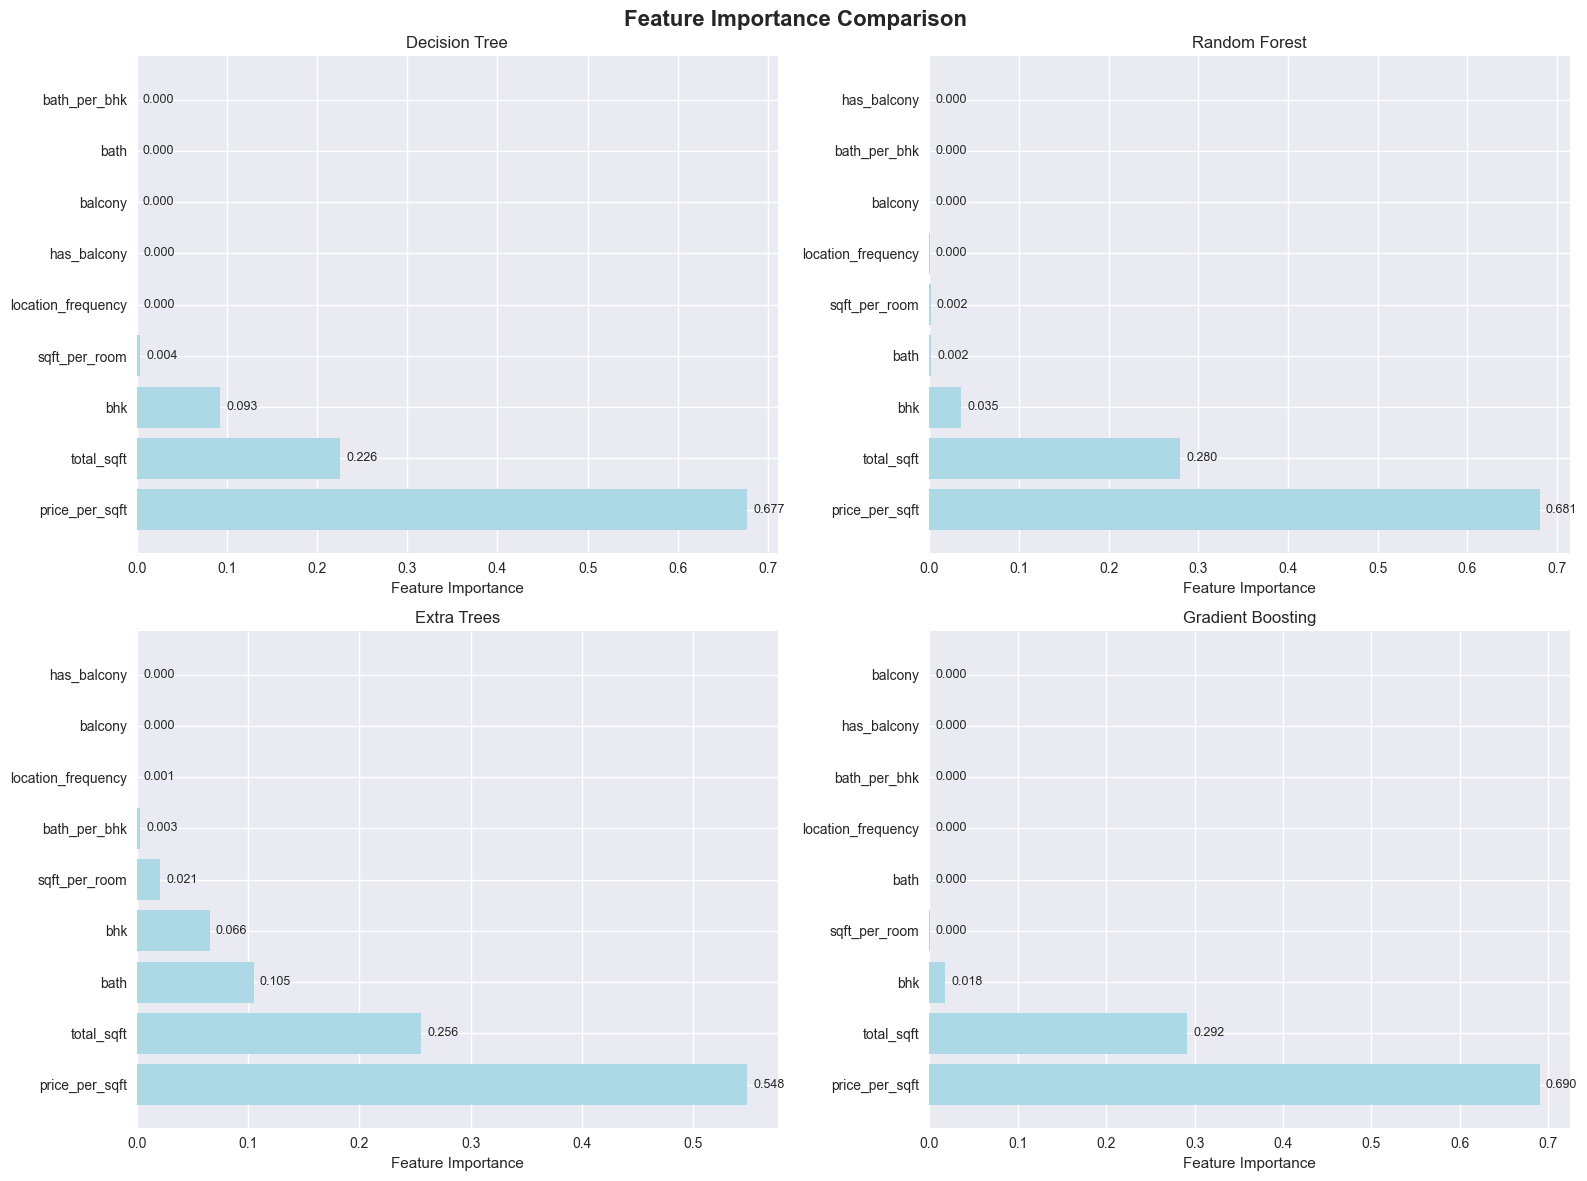


📊 Feature Importance Summary:
Average feature importance across tree-based models:
   price_per_sqft: 0.6489
   total_sqft: 0.2633
   bhk: 0.0529
   bath: 0.0268
   sqft_per_room: 0.0067
   bath_per_bhk: 0.0008
   location_frequency: 0.0003
   balcony: 0.0002
   has_balcony: 0.0002


In [9]:
# Feature importance analysis for tree-based models
print("🌳 Feature Importance Analysis...")

# Get feature importance from tree-based models
importance_results = {}

tree_models = ['Decision Tree', 'Random Forest', 'Extra Trees', 'Gradient Boosting']

for model_name in tree_models:
    if model_name in test_results and test_results[model_name] is not None:
        model = test_results[model_name]['model']
        
        if hasattr(model, 'feature_importances_'):
            importance_results[model_name] = dict(zip(
                X_train.columns, 
                model.feature_importances_
            ))

if importance_results:
    # Create feature importance comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Importance Comparison', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for idx, (model_name, importance) in enumerate(importance_results.items()):
        if idx < 4:
            ax = axes[idx]
            
            features = list(importance.keys())
            importances = list(importance.values())
            
            # Sort by importance
            sorted_idx = np.argsort(importances)[::-1]
            features_sorted = [features[i] for i in sorted_idx]
            importances_sorted = [importances[i] for i in sorted_idx]
            
            bars = ax.barh(features_sorted, importances_sorted, color='lightblue')
            ax.set_title(f'{model_name}')
            ax.set_xlabel('Feature Importance')
            
            # Add value labels
            for bar, imp in zip(bars, importances_sorted):
                width = bar.get_width()
                ax.text(width + max(importances_sorted)*0.01, 
                       bar.get_y() + bar.get_height()/2,
                       f'{imp:.3f}', ha='left', va='center', fontsize=9)
    
    # Remove empty subplots
    for idx in range(len(importance_results), 4):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance summary
    print(f"\n📊 Feature Importance Summary:")
    
    # Average importance across all tree models
    all_features = set()
    for importance in importance_results.values():
        all_features.update(importance.keys())
    
    avg_importance = {}
    for feature in all_features:
        importances = [importance.get(feature, 0) for importance in importance_results.values()]
        avg_importance[feature] = np.mean(importances)
    
    # Sort by average importance
    sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
    
    print("Average feature importance across tree-based models:")
    for feature, importance in sorted_features:
        print(f"   {feature}: {importance:.4f}")

else:
    print("⚠️ No tree-based models available for feature importance analysis")


In [10]:
# Hyperparameter tuning for top performing models
print("🎛️ Hyperparameter Tuning for Top Models...")

# Select top 3 models for tuning
top_models = results_df.head(3)['Model'].tolist()
print(f"Tuning hyperparameters for: {top_models}")

tuned_results = {}

for model_name in top_models:
    print(f"\n🔧 Tuning {model_name}...")
    
    try:
        if model_name == 'Random Forest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
            
        elif model_name == 'Gradient Boosting':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            base_model = GradientBoostingRegressor(random_state=42)
            
        elif model_name == 'Ridge Regression':
            param_grid = {
                'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
            }
            base_model = Ridge(random_state=42)
            
        elif model_name == 'Extra Trees':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            base_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
            
        else:
            print(f"   ⚠️ No tuning configuration for {model_name}")
            continue
        
        # Use RandomizedSearchCV for efficiency
        random_search = RandomizedSearchCV(
            base_model,
            param_distributions=param_grid,
            n_iter=20,  # Number of parameter settings sampled
            cv=3,  # 3-fold CV for speed
            scoring='r2',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        # Fit the random search
        random_search.fit(X_train, y_train)
        
        # Get best model
        best_model = random_search.best_estimator_
        
        # Evaluate best model
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        tuned_train_r2 = r2_score(y_train, y_train_pred)
        tuned_test_r2 = r2_score(y_test, y_test_pred)
        tuned_test_mae = mean_absolute_error(y_test, y_test_pred)
        
        # Compare with original
        original_test_r2 = test_results[model_name]['test_r2']
        improvement = tuned_test_r2 - original_test_r2
        
        tuned_results[model_name] = {
            'best_model': best_model,
            'best_params': random_search.best_params_,
            'best_cv_score': random_search.best_score_,
            'tuned_train_r2': tuned_train_r2,
            'tuned_test_r2': tuned_test_r2,
            'tuned_test_mae': tuned_test_mae,
            'improvement': improvement,
            'predictions': y_test_pred
        }
        
        print(f"   Best parameters: {random_search.best_params_}")
        print(f"   Original Test R²: {original_test_r2:.4f}")
        print(f"   Tuned Test R²: {tuned_test_r2:.4f}")
        print(f"   Improvement: {improvement:.4f}")
        
        if improvement > 0.01:
            print(f"   ✅ Significant improvement achieved!")
        else:
            print(f"   ➡️ Marginal improvement")
            
    except Exception as e:
        print(f"   ❌ Tuning failed: {str(e)}")

print(f"\n✅ Hyperparameter tuning completed")


🎛️ Hyperparameter Tuning for Top Models...
Tuning hyperparameters for: ['Random Forest', 'Extra Trees', 'Gradient Boosting']

🔧 Tuning Random Forest...
   Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
   Original Test R²: 0.9947
   Tuned Test R²: 0.9947
   Improvement: -0.0001
   ➡️ Marginal improvement

🔧 Tuning Extra Trees...
   Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
   Original Test R²: 0.9930
   Tuned Test R²: 0.9931
   Improvement: 0.0001
   ➡️ Marginal improvement

🔧 Tuning Gradient Boosting...
   Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.1}
   Original Test R²: 0.9920
   Tuned Test R²: 0.9955
   Improvement: 0.0035
   ➡️ Marginal improvement

✅ Hyperparameter tuning completed


In [11]:
# Final model selection and saving
print("💾 Final Model Selection and Saving...")

# Determine the best model (considering tuned versions)
best_final_model = None
best_final_score = -np.inf
best_final_name = None

# Check original models
for name, results in test_results.items():
    if results is not None and results['test_r2'] > best_final_score:
        best_final_score = results['test_r2']
        best_final_model = results['model']
        best_final_name = name

# Check tuned models
for name, results in tuned_results.items():
    if results['tuned_test_r2'] > best_final_score:
        best_final_score = results['tuned_test_r2']
        best_final_model = results['best_model']
        best_final_name = f"{name} (Tuned)"

print(f"\n🏆 Final Best Model: {best_final_name}")
print(f"   Test R² Score: {best_final_score:.4f}")

# Save the best model and related components
models_dir = Path('../models/trained_models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save best model
joblib.dump(best_final_model, models_dir / 'best_model.pkl')
print(f"✅ Best model saved: {models_dir / 'best_model.pkl'}")

# Save scaler if used
if best_final_name in ['Support Vector Regression', 'K-Nearest Neighbors']:
    joblib.dump(scaler, models_dir / 'feature_scaler.pkl')
    print(f"✅ Feature scaler saved: {models_dir / 'feature_scaler.pkl'}")

# Save location encoder if used
if 'location_encoded' in X_train.columns:
    try:
        joblib.dump(le_location, models_dir / 'location_encoder.pkl')
        print(f"✅ Location encoder saved: {models_dir / 'location_encoder.pkl'}")
    except:
        print("⚠️ Location encoder not available to save")

# Save model metadata
metadata = {
    'best_model_name': best_final_name,
    'best_model_type': type(best_final_model).__name__,
    'test_r2_score': best_final_score,
    'feature_columns': list(X_train.columns),
    'training_date': datetime.now().isoformat(),
    'dataset_size': {
        'train': X_train.shape[0],
        'test': X_test.shape[0],
        'features': X_train.shape[1]
    },
    'model_comparison': results_df.to_dict('records'),
    'hyperparameter_tuning': {name: results['best_params'] for name, results in tuned_results.items()}
}

joblib.dump(metadata, models_dir / 'model_metadata.pkl')
print(f"✅ Model metadata saved: {models_dir / 'model_metadata.pkl'}")

print(f"\n🎉 Model experiments completed successfully!")
print(f"📊 Experiment Summary:")
print(f"   Models tested: {len(models)}")
print(f"   Models successfully trained: {len([r for r in test_results.values() if r is not None])}")
print(f"   Models hyperparameter tuned: {len(tuned_results)}")
print(f"   Best model: {best_final_name}")
print(f"   Best R² score: {best_final_score:.4f}")
print(f"\n✅ Ready for deployment!")


💾 Final Model Selection and Saving...

🏆 Final Best Model: Gradient Boosting (Tuned)
   Test R² Score: 0.9955
✅ Best model saved: ../models/trained_models/best_model.pkl
✅ Model metadata saved: ../models/trained_models/model_metadata.pkl

🎉 Model experiments completed successfully!
📊 Experiment Summary:
   Models tested: 10
   Models successfully trained: 10
   Models hyperparameter tuned: 3
   Best model: Gradient Boosting (Tuned)
   Best R² score: 0.9955

✅ Ready for deployment!


In [12]:
# Create final performance summary
print("📋 Final Model Performance Summary")

# Create comprehensive comparison including tuned models
final_comparison = []

# Add original models
for name, results in test_results.items():
    if results is not None:
        final_comparison.append({
            'Model': name,
            'Type': 'Original',
            'Test_R2': results['test_r2'],
            'Test_MAE': results['test_mae'],
            'Test_RMSE': results['test_rmse'],
            'CV_R2_Mean': results['cv_r2_mean'],
            'Overfitting': results['train_r2'] - results['test_r2']
        })

# Add tuned models
for name, results in tuned_results.items():
    final_comparison.append({
        'Model': f"{name} (Tuned)",
        'Type': 'Tuned',
        'Test_R2': results['tuned_test_r2'],
        'Test_MAE': results['tuned_test_mae'],
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, results['predictions'])),
        'CV_R2_Mean': results['best_cv_score'],
        'Overfitting': results['tuned_train_r2'] - results['tuned_test_r2']
    })

final_df = pd.DataFrame(final_comparison)
final_df = final_df.sort_values('Test_R2', ascending=False)

print("\n🏆 Final Model Rankings:")
display(final_df.round(4))

# Performance insights
print(f"\n💡 Key Insights:")
print(f"   • Best performing model: {final_df.iloc[0]['Model']}")
print(f"   • Highest R² score: {final_df.iloc[0]['Test_R2']:.4f}")
print(f"   • Lowest MAE: {final_df['Test_MAE'].min():.2f} lakhs")

# Model type performance
model_type_performance = final_df.groupby('Type')['Test_R2'].agg(['mean', 'max', 'count'])
print(f"\n📊 Performance by Model Type:")
display(model_type_performance.round(4))

if len(tuned_results) > 0:
    avg_improvement = np.mean([r['improvement'] for r in tuned_results.values()])
    print(f"\n🎛️ Hyperparameter Tuning Impact:")
    print(f"   Average R² improvement: {avg_improvement:.4f}")
    
    significant_improvements = sum(1 for r in tuned_results.values() if r['improvement'] > 0.01)
    print(f"   Models with significant improvement: {significant_improvements}/{len(tuned_results)}")

print(f"\n✅ Model experiments analysis completed at: {datetime.now()}")


📋 Final Model Performance Summary

🏆 Final Model Rankings:


,Model,Type,Test_R2,Test_MAE,Test_RMSE,CV_R2_Mean,Overfitting
12,Gradient Boosting (Tuned),Tuned,0.9955,0.8910,2.6270,0.9983,0.0040
5,Random Forest,Original,0.9947,0.6245,2.8419,0.9977,0.0050
10,Random Forest (Tuned),Tuned,0.9947,0.6377,2.8587,0.9980,0.0050
11,Extra Trees (Tuned),Tuned,0.9931,0.4769,3.2507,0.9986,0.0069
6,Extra Trees,Original,0.9930,0.4874,3.2781,0.9986,0.0070
7,Gradient Boosting,Original,0.9920,1.4936,3.5075,0.9966,0.0057
4,Decision Tree,Original,0.9891,1.2686,4.0926,0.9945,0.0109
8,K-Nearest Neighbors,Original,0.9600,3.6325,7.8455,0.9879,0.0200
0,Linear Regression,Original,0.9237,4.9140,10.8326,0.9593,0.0363
1,Ridge Regression,Original,0.9237,4.9146,10.8340,0.9593,0.0363



💡 Key Insights:
   • Best performing model: Gradient Boosting (Tuned)
   • Highest R² score: 0.9955
   • Lowest MAE: 0.48 lakhs

📊 Performance by Model Type:


,mean,max,count
Type,,,
Original,0.9481,0.9947,10
Tuned,0.9944,0.9955,3



🎛️ Hyperparameter Tuning Impact:
   Average R² improvement: 0.0012
   Models with significant improvement: 0/3

✅ Model experiments analysis completed at: 2025-10-03 16:23:33.467053
